### 2D Adjustment

This notebook refines the computed UMAP x/y coordinates based on the classes and probabilities and achieves more locally structured clusters.

In [1]:
import json
import os
import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
import networkx as nx

In [2]:
# Specify paths for metadata
DATA_DIR          = 'data'
YAMNET_FILE       = os.path.join(DATA_DIR, 'eval_clips_info_FSD50K_analysis_refinement_umap_refined.json')
YAMNET_FILE_ORIG  = os.path.join(DATA_DIR, 'eval_clips_info_FSD50K_analysis_refinement_umap_unrefined.json')
ONTOLOGY_JSON     = os.path.join(DATA_DIR, 'ontology.json')
FSD50K_VOCABULARY = os.path.join(DATA_DIR, 'vocabulary.csv')
ONTOLOGY_TREE_L1  = os.path.join(DATA_DIR, 'ontology_layer_1.csv')
ONTOLOGY_TREE_L2  = os.path.join(DATA_DIR, 'ontology_layer_2.csv')
ONTOLOGY_TREE_L3  = os.path.join(DATA_DIR, 'ontology_layer_3.csv')
COLORPALETTE_200  = os.path.join(DATA_DIR, 'colorpalette-200.npy')
COLORPALETTE_300  = os.path.join(DATA_DIR, 'colorpalette-300.npy')

In [3]:
# Load metadata JSON
yamnet_df      = pd.read_json(YAMNET_FILE)
yamnet_df_orig = pd.read_json(YAMNET_FILE)

# Load first two layers of ontology buckets
tree_l1_df   = pd.read_csv(ONTOLOGY_TREE_L1, index_col=0).T
tree_l2_df   = pd.read_csv(ONTOLOGY_TREE_L2, index_col=0).T
tree_l3_df   = pd.read_csv(ONTOLOGY_TREE_L3, index_col=0).T
tree_l1_dict = utils.getOntoDict(tree_l1_df)
tree_l2_dict = utils.getOntoDict(tree_l2_df)
tree_l3_dict = utils.getOntoDict(tree_l3_df)
merged_dict  = tree_l1_dict | tree_l2_dict | tree_l3_dict
                               
# Ontology translation
onto_df         = pd.read_json(ONTOLOGY_JSON)
fsdk_df         = pd.read_csv(FSD50K_VOCABULARY, header=None)
fsdk_name_to_id = dict(zip(fsdk_df[1], fsdk_df[2]))
onto_name_to_id = dict(zip(onto_df['name'], onto_df['id']))
fsdk_id_to_name = dict(zip(fsdk_df[2], fsdk_df[1]))
onto_id_to_name = dict(zip(onto_df['id'], onto_df['name']))

ontology_str = ['Human sounds', 'Source-ambiguous sounds', 'Animal', 'Sounds of things', 'Music', 'Natural sounds', 'Channel, environment and background']
ontology_ids = [onto_name_to_id[x] for x in ontology_str]

# Save IDs of the 632 ontology classes
all_onto_classes_ids = list(set([c_id for c_id in onto_df['id']]) - set(ontology_ids))
all_onto_classes     = [onto_id_to_name[c_id] for c_id in all_onto_classes_ids]
layer2_classes       = [onto_id_to_name[x] for x in tree_l2_dict.keys()]
layer3_classes       = [onto_id_to_name[x] for x in tree_l3_dict.keys()]
layer1_2_classes     = np.concatenate((ontology_str, layer2_classes))

# Init graph
G = nx.DiGraph()
for key, item in onto_df.iterrows():
    item_id   = item['id']
    child_ids = item['child_ids']    
    for ids in child_ids:
        G.add_edge(item_id, ids)

yamnet_df.head()

,file_id,title,user_tags,yamnet_class,yamnet_class_id,yamnet_prob_classes,yamnet_embedding,refined_classes_ids,refined_classes,layer1_id,layer2_id,layer3_id,unrefined_layer1_id,unrefined_layer2_id,unrefined_layer3_id,xypos
0,348190,000_forest2.wav,"[bird, nature, forest, birds]",Animal,/m/0jbk,"[[Animal, 0.7190098166000001], [Turkey, 0.4758...","[0.0, 0.0, 1.374760747, 0.009943426600000001, ...",/m/015p6,Bird,/m/0jbk,/m/01280g,/m/015p6,/m/0jbk,/m/0jbk,/m/0jbk,"[-16.2312545776, 6.7351379395]"
1,205659,20131106_Elevator Door Opening_ZoomH6XY.wav,"[door, university, indoor, soundscape-leuphana...","Inside, small room",/t/dd00125,"[[Inside, small room, 0.2220406979], [Bathtub ...","[0.0, 0.0, 0.162363857, 0.0153112067, 0.0, 0.0...",/m/02dgv,Door,/t/dd00041,/t/dd00071,/m/02dgv,/t/dd00123,/t/dd00093,/t/dd00125,"[4.4450392723, 23.5398826599]"
2,319403,tropical rain 2.wav,"[shower, raining, weather, rain, nature]",Water,/m/0838f,"[[Water, 0.4808812141], [Rain, 0.3934635818], ...","[0.0, 0.0, 0.0, 0.009430388000000001, 0.0, 0.0...",/m/06mb1,Rain,/m/059j3w,/m/0838f,/m/06mb1,/m/059j3w,/m/0838f,/m/0838f,"[-4.5314502716, 26.1648178101]"
3,48080,2_9_2008_joey misc.mp3,"[acoustic, concrete, dada, experimental, feel-...",Music,/m/04rlf,"[[Music, 0.21976216140000002], [Vehicle horn, ...","[0.0, 0.0, 0.8523207307, 0.2249663621, 0.0, 0....",/t/dd00032,Funny music,/m/04rlf,/t/dd00030,/t/dd00032,/m/04rlf,/m/04rlf,/m/04rlf,"[-8.5366296768, 11.6980667114]"
4,408627,12. Motor sin acelerar.wav,"[automobile, car, engine]",Percussion,/m/0l14md,"[[Percussion, 0.30112293360000003], [Drum, 0.2...","[0.0, 0.0, 0.3867293894, 0.0, 0.0, 0.0, 0.0, 0...",/m/05rj2,Shuffling cards,/t/dd00041,/t/dd00071,/m/05rj2,/m/04rlf,/m/04szw,/m/0l14md,"[3.5651674271, 23.1574172974]"


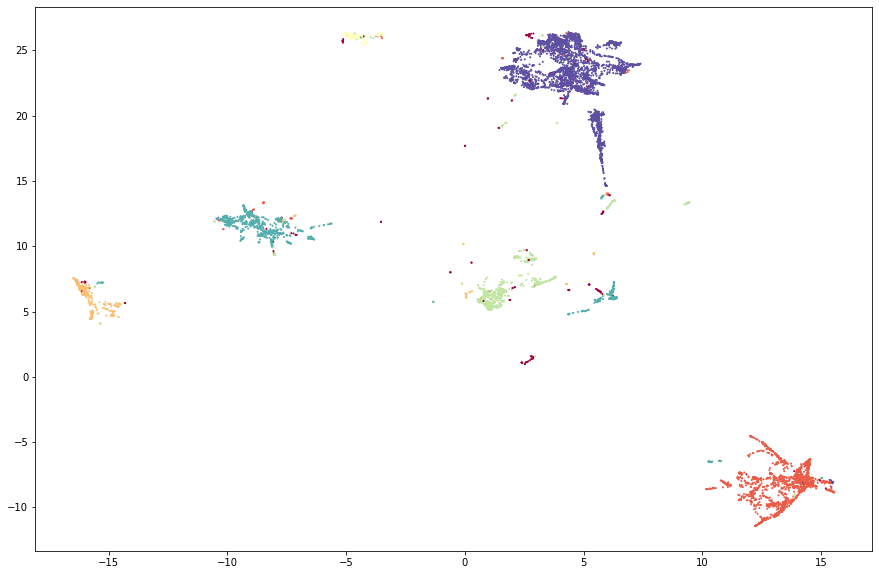

In [4]:
# Plot precomputed UMAP embeddings
fig, ax = plt.subplots(1,1, figsize=(15,10))
X = np.array(yamnet_df['xypos'].tolist())[:,0]
Y = np.array(yamnet_df['xypos'].tolist())[:,1]
colormap = utils.getColormap(yamnet_df['layer1_id'])
ax.scatter(X,Y,cmap='Spectral', c=colormap, s=1.0);

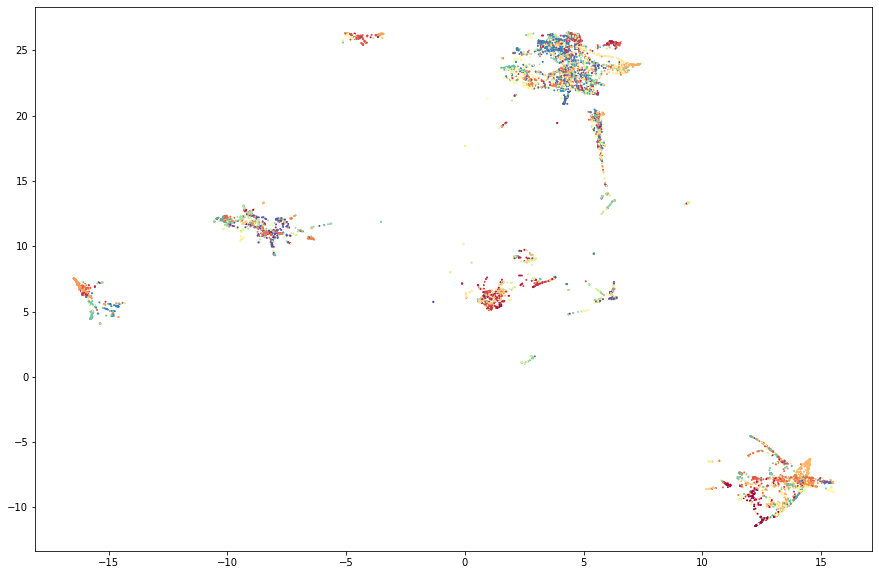

In [5]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
X = np.array(yamnet_df['xypos'].tolist())[:,0]
Y = np.array(yamnet_df['xypos'].tolist())[:,1]
colormap = utils.getColormap(yamnet_df['layer3_id'])
ax.scatter(X,Y,cmap='Spectral', c=colormap, s=1.0);

In [6]:
def getBucketKey(class_id):
    for key, bucket in tree_l2_dict.items():
        if class_id in bucket:
            return key

# Refine the points of samples belonging to layer 3 of the ontology
refined_points = {}
l1_centroids   = {}
l2_centroids   = {}
for class_id in ontology_ids:
    sub_classes = yamnet_df.loc[yamnet_df['layer1_id'] == class_id].groupby('layer3_id')['xypos']
    
    for key, item in sub_classes:
        points      = np.array(item.tolist())
        points_keys = np.array(item.keys().tolist())
        iterations  = int(len(points) * 2)
        
        # Point refinement
        for i in range(iterations): 
            # Compute centroid
            centroid  = utils.computeCentroid(points)
            # Compute distances
            distances = utils.computeDistances(points, centroid)
            max_p_idx = utils.getMaxValIndex(distances)
            far_point = points[max_p_idx]
            df_idx    = points_keys[max_p_idx]
            probInit  = yamnet_df.at[df_idx, 'yamnet_prob_classes']
            probDict  = []
            
            for c in probInit:
                if c[0] not in layer1_2_classes:
                    probDict.append(c)
            
            probDict = dict(probDict)
            
            buck_key  = getBucketKey(yamnet_df.at[df_idx, 'refined_classes_ids'])
            bucket    = [onto_id_to_name[x] for x in tree_l2_dict[buck_key]]
            prob      = utils.sumProbabilites(probDict, bucket)
            new_point = utils.reduceDistance(far_point, centroid, prob)
            # Set the new point position
            points[max_p_idx] = new_point
        
        for i, k in enumerate(points_keys):
            refined_points[k] = points[i]
        

# Put refined points into dataframe
ord_refined_points = collections.OrderedDict(sorted(refined_points.items()))   
points_array = [val for key, val in ord_refined_points.items()]    
yamnet_df['refined_xypos'] = points_array


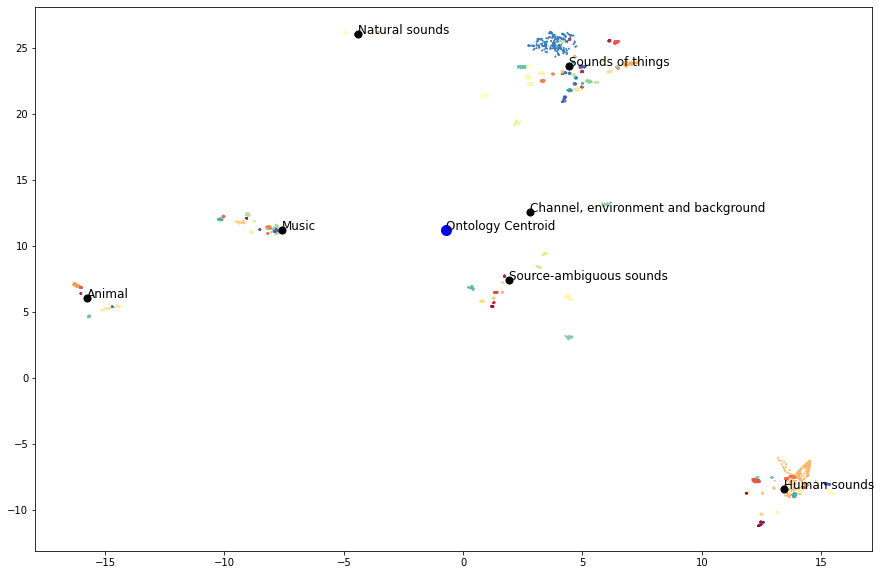

In [7]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
X = np.array(yamnet_df['refined_xypos'].tolist())[:,0]
Y = np.array(yamnet_df['refined_xypos'].tolist())[:,1]
colormap = utils.getColormap(yamnet_df['layer3_id'])
ax.scatter(X,Y,cmap='Spectral', c=colormap, s=1.0)

# Plot Centroids
l1_centroids = {}
for class_ids in ontology_ids:
    sub_df = yamnet_df.loc[yamnet_df['layer1_id'] == class_ids]['refined_xypos']
    points = np.array(sub_df.tolist())
    if len(points) == 0:
        continue
    l1_centroid = utils.computeCentroid(points)
    l1_centroids[class_ids] = l1_centroid
    ax.scatter(l1_centroid[0], l1_centroid[1], c='black', s=50.0)
    ax.text(l1_centroid[0], l1_centroid[1], onto_id_to_name[class_ids], fontsize=12)


p = np.array(list(l1_centroids.values()))
onto_centroid = utils.computeCentroid(p)
ax.scatter(onto_centroid[0], onto_centroid[1], s=100.0, c='blue')
ax.text(onto_centroid[0], onto_centroid[1], 'Ontology Centroid', fontsize=12);

In [8]:
# Pull far away clusters a little closer 
# Displace cluster positions of layer 3 clusters closer to their parent
for class_id in ontology_ids:
    
    sucs = list(G.successors(class_id))
    sub_parent_df  = yamnet_df.loc[yamnet_df['layer1_id'] == class_id]['refined_xypos']
    points = np.array(sub_parent_df.tolist())
    p_centroid = np.array(utils.computeCentroid(points))
    
    for l in range(len(sucs)):
        layer2_centroids = []
        sucs_copy = sucs
        for idx, i in enumerate(sucs):
            sub_classes_df = yamnet_df.loc[yamnet_df['layer2_id'] == i]['refined_xypos']
            if len(list(sub_classes_df)) == 0:
                sucs_copy.pop(idx)
                continue
            subpoints = np.array(list(sub_classes_df))
            centroid = utils.computeCentroid(subpoints)
            layer2_centroids.append(centroid)
        
        p_dist_sub = utils.computeDistances(layer2_centroids, p_centroid)
        max_idx = utils.getMaxValIndex(p_dist_sub)
        max_id  = sucs_copy[max_idx]
        
        dist_p_sub_midpoint = (layer2_centroids[max_idx] + p_centroid) / 2.0
        
        far_group = yamnet_df.loc[yamnet_df['layer2_id'] == max_id]['refined_xypos']
        far_group_keys = list(far_group.keys())
        far_group_points = list(far_group)
        new_points = utils.shiftPoints(far_group_points, dist_p_sub_midpoint)
        
        for i, key in enumerate(far_group_keys):
            yamnet_df.at[key, 'refined_xypos'] = list(new_points[i])


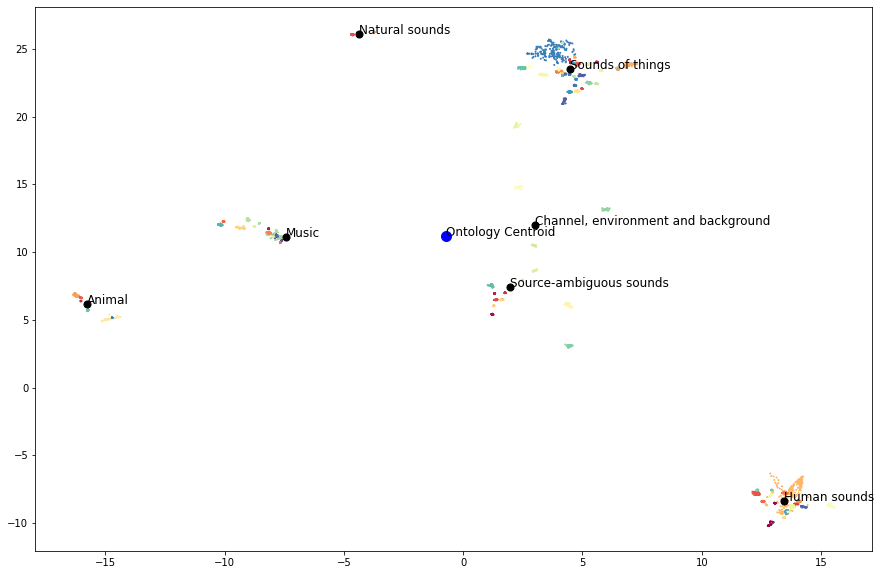

In [9]:
fig, ax = plt.subplots(1,1, figsize=(15,10))

X = np.array(yamnet_df['refined_xypos'].tolist())[:,0]
Y = np.array(yamnet_df['refined_xypos'].tolist())[:,1]
colormap = utils.getColormap(yamnet_df['layer3_id'])
ax.scatter(X,Y,cmap='Spectral', c=colormap, s=1.0)
 
# Plot Centroids
l1_centroids = {}
for class_ids in ontology_ids:
    sub_df = yamnet_df.loc[yamnet_df['layer1_id'] == class_ids]['refined_xypos']
    points = np.array(sub_df.tolist())
    if len(points) == 0:
        continue
    l1_centroid = utils.computeCentroid(points)
    l1_centroids[class_ids] = l1_centroid
    ax.scatter(l1_centroid[0], l1_centroid[1], c='black', s=50.0)
    ax.text(l1_centroid[0], l1_centroid[1], onto_id_to_name[class_ids], fontsize=12)

ax.scatter(onto_centroid[0], onto_centroid[1], s=100.0, c='blue')
ax.text(onto_centroid[0], onto_centroid[1], 'Ontology Centroid', fontsize=12);

In [10]:
# Color stuff
import colorutils
import random
import random
from skimage import io
from skimage.color import rgb2lab, deltaE_cie76

# RGB reference
rgb = io.imread('https://i.stack.imgur.com/npnrv.png')

# Generate distinct color palette
def getColorPalette(color, num_classes, rgb_img, threshold=100):
    lab      = rgb2lab(rgb_img)
    color_3d = np.uint8(np.asarray([[color]]))
    dE       = deltaE_cie76(rgb2lab(color_3d), lab)
    c_amount = len(rgb[dE < threshold])
    if c_amount == 0:
        return []
    chunks   = c_amount // num_classes
    palette  = np.array([rgb[dE < threshold][i * chunks] for i in range(num_classes)])
    return palette
   
def printColors(colors):
    if len(colors) != 0:
        indices = np.array([np.arange(len(colors))])
        plt.imshow(colors[indices])
        plt.show()

opt_palette    = colorutils.optimalPalette()[6:-1]
kelly_pallette = colorutils.toRGBColors(colorutils.kellyPalette())
palette_200    = np.load(COLORPALETTE_200)
palette_300    = np.load(COLORPALETTE_300)

# Create color palettes for layers
colors = {}
l1_colors = {}
l2_colors = {}
l3_colors = {}

# Create color schemes for layer 1-3
for idx, s in enumerate(ontology_ids):
    l1_color = opt_palette[idx]
    l1_colors[s] = l1_color
    sub_classes = list(set(yamnet_df.loc[yamnet_df['layer1_id'] == s]['layer2_id'].tolist()))  
    l2_palette = getColorPalette(l1_color, len(sub_classes), rgb, 50)    
    for idx, c in enumerate(sub_classes):
        l2_color = l2_palette[idx]
        subs = list(set(yamnet_df.loc[yamnet_df['layer2_id'] == c]['layer3_id'].tolist()))
        l2_colors[c] = l2_color
        l3_palette = getColorPalette(l2_color, len(subs), rgb, 50)     
        for idx, c in enumerate(subs):
            colors[c] = l3_palette[idx]
            l3_colors[c] = l3_palette[idx]

In [11]:
# Load audio urls
with open ('urls.json', 'r') as f:
    urls = json.load(f)


In [12]:
'''
Create the JSON file for the sound map visualizer interface for the refined map layout
The following code is collecting all information for the refined map layout
'''

sound_map_dict = {}
results = []

for i, row in yamnet_df.iterrows():
    file_id  = row['file_id']
    name     = row['title']
    # audio    = 'audio_files/' + str(file_id) + '.wav'
    audio    = str(urls[str(file_id)]['audio_url'])
    username = 'none'
    url      = str(urls[str(file_id)]['url'])
    image    = ''
    vals     = {'x': row['refined_xypos'][0], 'y' : row['refined_xypos'][1]}
    color    = colors[row['layer3_id']] / 255.0
    cols     = {'mean': list(color)}
    tri      = {'tristimulus' : cols}
    analysis = {'vals' : vals, 'sfx': tri}
    layer1   = onto_id_to_name[row['layer1_id']]
    layer2   = onto_id_to_name[row['layer2_id']]
    layer3   = onto_id_to_name[row['layer3_id']]
    y_class  = row['refined_classes']
   
    temp_dict = {}
    temp_dict['id'] = int(file_id)
    temp_dict['url'] = url
    temp_dict['name'] = name
    temp_dict['analysis'] = analysis
    temp_dict['audio'] = audio
    temp_dict['image'] = image
    temp_dict['layer1'] = str(layer1)
    temp_dict['layer2'] = str(layer2)
    temp_dict['layer3'] = str(layer3)
    temp_dict['ref_class'] = str(y_class)
    
    results.append(temp_dict)

sound_map_dict['results'] = results


# Layer 1 centroids
l1_centroids = []
for class_ids in ontology_ids:
    l1_labels = {}
    l1_centr  = {}
    l1_color  = {}
    sub_df = yamnet_df.loc[yamnet_df['layer1_id'] == class_ids]['refined_xypos']
    points = np.array(sub_df.tolist())
    l1_centroid = utils.computeCentroid(points)
    l1_centr['Centroid'] = list(l1_centroid)
    l1_color['Color']    = list(l1_colors[class_ids] / 255.0)
    l1_labels[onto_id_to_name[class_ids]] = l1_centr | l1_color
    l1_centroids.append(l1_labels)
       
sound_map_dict['l1_centroids'] = list(l1_centroids)

# Layer 2 centroids

l2_centroids = []
for class_ids in tree_l2_dict.keys():
    l2_labels = {}
    l2_centr  = {}
    l2_color  = {}
    sub_df = yamnet_df.loc[yamnet_df['layer2_id'] == class_ids]['refined_xypos']
    if len(sub_df) == 0:
        continue
    points = np.array(sub_df.tolist())
    l2_centroid = utils.computeCentroid(points)
    l2_centr['Centroid'] = list(l2_centroid)
    l2_color['Color']    = list(l2_colors[class_ids] / 255.0)
    l2_labels[onto_id_to_name[class_ids]] = l2_centr | l2_color
    l2_centroids.append(l2_labels)

sound_map_dict['l2_centroids'] = list(l2_centroids)
    
# Layer 3 centroids
l3_centroids = []
for class_ids in tree_l3_dict.keys():
    l3_labels = {}
    l3_centr  = {}
    l3_color  = {}
    sub_df = yamnet_df.loc[yamnet_df['layer3_id'] == class_ids]['refined_xypos']
    if len(sub_df) == 0:
        continue
    points = np.array(sub_df.tolist())
    l3_centroid = utils.computeCentroid(points)
    l3_centr['Centroid'] = list(l3_centroid)
    l3_color['Color']    = list(l3_colors[class_ids] / 255.0)
    l3_labels[onto_id_to_name[class_ids]] = l3_centr | l3_color
    l3_centroids.append(l3_labels)
    
sound_map_dict['l3_centroids'] = list(l3_centroids)

In [13]:
with open('sound_map_dict_refined.json', 'w') as outfile:
    json.dump(sound_map_dict, outfile)

In [14]:
'''
Create the JSON file for the sound map visualizer interface for the refined map layout
The following code is collecting all information for the base map layout
'''

random.shuffle(opt_palette)
# Create color palettes for layers
colors = {}
l1_colors = {}
l2_colors = {}
l3_colors = {}
for idx, s in enumerate(ontology_ids):
    l1_color = opt_palette[idx]
    l1_colors[s] = l1_color
    sub_classes = list(set(yamnet_df_orig.loc[yamnet_df_orig['unrefined_layer1_id'] == s]['unrefined_layer2_id'].tolist()))  
    l2_palette = getColorPalette(l1_color, len(sub_classes), rgb, 50)    
    for idx, c in enumerate(sub_classes):
        l2_color = l2_palette[idx]
        subs = list(set(yamnet_df_orig.loc[yamnet_df_orig['unrefined_layer2_id'] == c]['unrefined_layer3_id'].tolist()))
        l2_colors[c] = l2_color
        l3_palette = getColorPalette(l2_color, len(subs), rgb, 50)     
        for idx, c in enumerate(subs):
            colors[c] = l3_palette[idx]
            l3_colors[c] = l3_palette[idx]


# Create JSON for sound map visualizer
# Unrefined points
sound_map_dict_unrefined = {}
results = []

classes = list(set(yamnet_df_orig['yamnet_class']))
colors_dict = dict(zip(classes, palette_300[:len(classes)]))
all_files_ids = []

for i, row in yamnet_df_orig.iterrows():
   
    file_id  = row['file_id']
    name     = row['title']
    # audio    = 'audio_files/' + str(file_id) + '.wav'
    audio    = str(urls[str(file_id)]['audio_url'])
    username = 'none'
    url      = str(urls[str(file_id)]['url'])
    image    = ''
    vals     = {'x': row['xypos'][0], 'y' : row['xypos'][1]}
    color    = colors_dict[row['yamnet_class']] / 255.0
    cols     = {'mean': list(color)}
    tri      = {'tristimulus' : cols}
    analysis = {'vals' : vals, 'sfx': tri}
    layer1   = onto_id_to_name[row['unrefined_layer1_id']]
    layer2   = onto_id_to_name[row['unrefined_layer2_id']]
    layer3   = onto_id_to_name[row['unrefined_layer3_id']]
    y_class  = row['yamnet_class']
    filename = str(file_id) + '.wav'
    all_files_ids.append(filename)
   
    temp_dict = {}
    temp_dict['id'] = int(file_id)
    temp_dict['url'] = url
    temp_dict['name'] = name
    temp_dict['analysis'] = analysis
    temp_dict['audio'] = audio
    temp_dict['image'] = image
    temp_dict['layer1'] = str(layer1)
    temp_dict['layer2'] = str(layer2)
    temp_dict['layer3'] = str(layer3)
    temp_dict['ref_class'] = str(y_class)
    
    results.append(temp_dict)

sound_map_dict_unrefined['results'] = results

# Layer 1 centroids
l1_centroids = []
for class_ids in ontology_ids:
    l1_labels = {}
    l1_centr  = {}
    l1_color  = {}
    sub_df = yamnet_df_orig.loc[yamnet_df_orig['unrefined_layer1_id'] == class_ids]['xypos']
    points = np.array(sub_df.tolist())
    l1_centroid = utils.computeCentroid(points)
    l1_centr['Centroid'] = list(l1_centroid)
    l1_color['Color']    = list(l1_colors[class_ids] / 255.0)
    l1_labels[onto_id_to_name[class_ids]] = l1_centr | l1_color
    l1_centroids.append(l1_labels)
    
    
sound_map_dict_unrefined['l1_centroids'] = list(l1_centroids)

# Layer 2 centroids

l2_centroids = []
for class_ids in tree_l2_dict.keys():
    l2_labels = {}
    l2_centr  = {}
    l2_color  = {}
    sub_df = yamnet_df_orig.loc[yamnet_df_orig['unrefined_layer2_id'] == class_ids]['xypos']
    if len(sub_df) == 0:
        continue
    points = np.array(sub_df.tolist())
    l2_centroid = utils.computeCentroid(points)
    l2_centr['Centroid'] = list(l2_centroid)
    l2_color['Color']    = list(l2_colors[class_ids] / 255.0)
    l2_labels[onto_id_to_name[class_ids]] = l2_centr | l2_color
    l2_centroids.append(l2_labels)

sound_map_dict_unrefined['l2_centroids'] = list(l2_centroids)
    
# Layer 3 centroids
l3_centroids = []
for class_ids in tree_l3_dict.keys():
    l3_labels = {}
    l3_centr  = {}
    l3_color  = {}
    sub_df = yamnet_df_orig.loc[yamnet_df_orig['unrefined_layer3_id'] == class_ids]['xypos']
    if len(sub_df) == 0:
        continue
    points = np.array(sub_df.tolist())
    l3_centroid = utils.computeCentroid(points)
    l3_centr['Centroid'] = list(l3_centroid)
    l3_color['Color']    = list(l3_colors[class_ids] / 255.0)
    l3_labels[onto_id_to_name[class_ids]] = l3_centr | l3_color
    l3_centroids.append(l3_labels)
    
sound_map_dict_unrefined['l3_centroids'] = list(l3_centroids)

In [15]:
with open('sound_map_dict_unrefined.json', 'w') as outfile:
    json.dump(sound_map_dict_unrefined, outfile)